In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_excel('../data/data.xlsx')

In [5]:
data.columns

Index(['Nombre y apellidos', 'Edad', 'Sexo', 'App HTA', 'App DM', 'App AB',
       'App Cardiopatía Isquémica', 'App Vasculitis', 'App Colagenopatías',
       'Etiología del empaquetamiento', 'Número de compresas utilizadas',
       'Horas transcurridas al desempaquetamiento',
       'Daño orgánico tubular asociado', 'Peritonitis asociada',
       'Lesión de vía biliar asociada',
       'Presencia de hipotensión arterial o shock  ', 'Tiempo quirúrgico',
       '# de hemoderivados  usados', 'componentes triada letal',
       'traumas asociado', 'VAM', 'Reempaquetamiento', 'Apache II', 'Sofa',
       'Estado al egreso'],
      dtype='object')

In [6]:
data.drop('Nombre y apellidos', axis=1, inplace = True)

Text(0, 0.5, 'Número de casos')

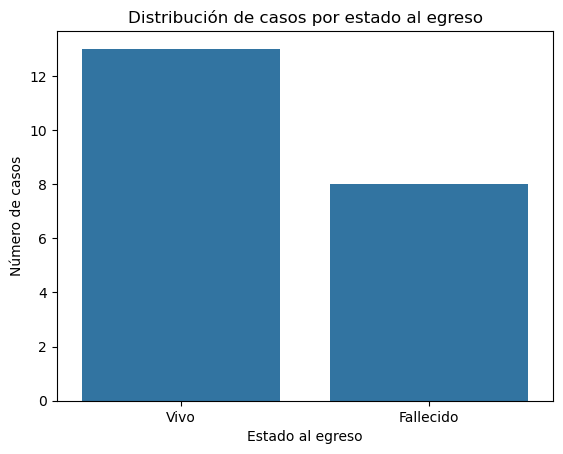

In [7]:
sns.countplot(x='Estado al egreso', data=data)
plt.title('Distribución de casos por estado al egreso')
plt.xticks(ticks=[0, 1], labels=['Vivo', 'Fallecido'])
plt.xlabel('Estado al egreso')
plt.ylabel('Número de casos')

In [8]:
data['Estado al egreso'].value_counts()

Estado al egreso
1    13
2     8
Name: count, dtype: int64

In [9]:
data.describe()

,Edad,Sexo,App HTA,App DM,App AB,App Cardiopatía Isquémica,App Vasculitis,App Colagenopatías,Etiología del empaquetamiento,Número de compresas utilizadas,...,Presencia de hipotensión arterial o shock,Tiempo quirúrgico,# de hemoderivados usados,componentes triada letal,traumas asociado,VAM,Reempaquetamiento,Apache II,Sofa,Estado al egreso
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.0,21.0,21.000000,21.000000,...,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,41.380952,1.238095,0.619048,0.857143,0.809524,0.809524,1.0,1.0,3.047619,2.047619,...,0.190476,2.809524,6.190476,1.904762,1.333333,0.380952,0.904762,14.142857,8.380952,1.380952
std,16.800227,0.436436,0.497613,0.358569,0.402374,0.402374,0.0,0.0,1.160870,0.669043,...,0.402374,0.749603,2.542028,0.768424,1.852926,0.497613,0.300793,8.332381,3.917604,0.497613
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.000000,1.000000,...,0.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,4.000000,3.000000,1.000000
25%,30.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.0,1.0,2.000000,2.000000,...,0.000000,2.000000,4.000000,1.000000,0.000000,0.000000,1.000000,8.000000,6.000000,1.000000
50%,41.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,3.000000,2.000000,...,0.000000,3.000000,6.000000,2.000000,0.000000,0.000000,1.000000,12.000000,7.000000,1.000000
75%,52.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,3.000000,2.000000,...,0.000000,3.000000,8.000000,2.000000,2.000000,1.000000,1.000000,20.000000,11.000000,2.000000
max,82.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,5.000000,3.000000,...,1.000000,4.000000,12.000000,3.000000,5.000000,1.000000,1.000000,33.000000,18.000000,2.000000


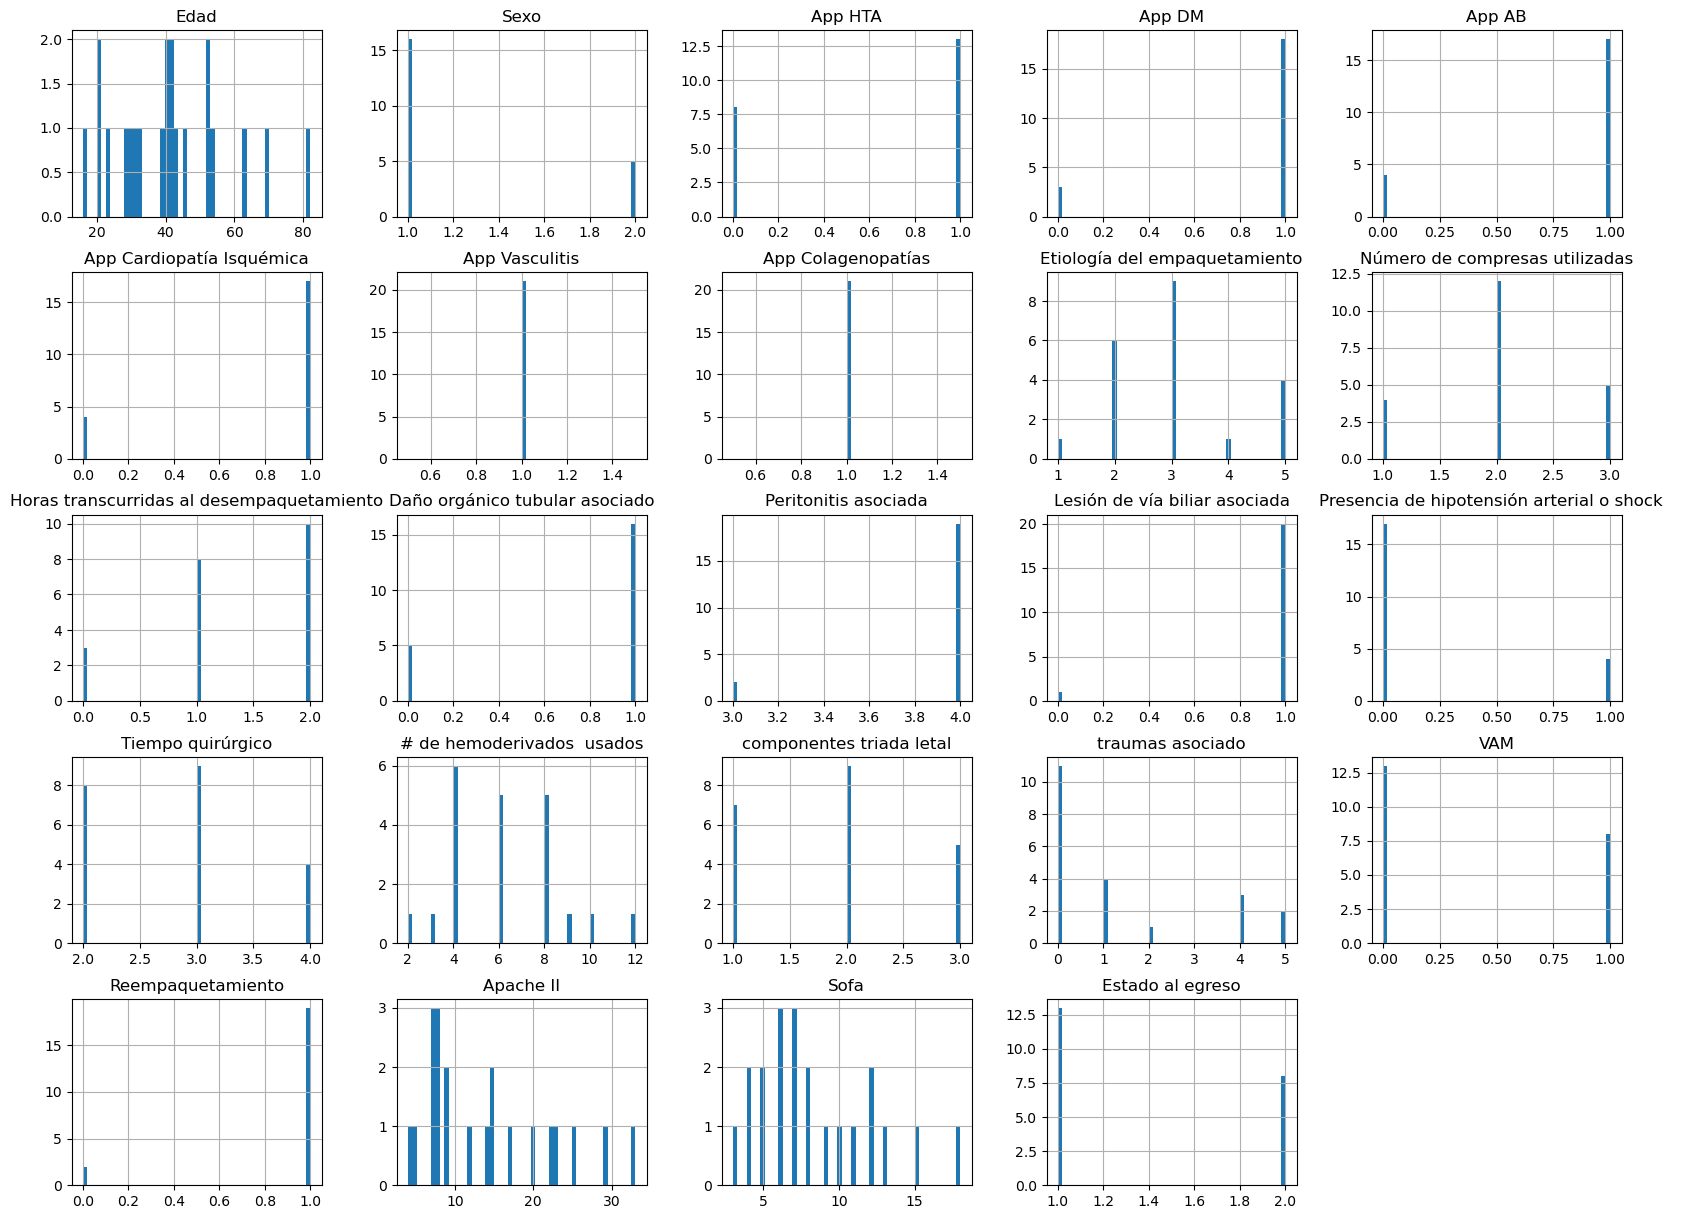

In [10]:
data.hist(bins=50, figsize=(20,15))
plt.show()

In [11]:
y = data['Estado al egreso']
X = data.drop('Estado al egreso', axis=1)
X.var(axis=0)

Edad                                           282.247619
Sexo                                             0.190476
App HTA                                          0.247619
App DM                                           0.128571
App AB                                           0.161905
App Cardiopatía Isquémica                        0.161905
App Vasculitis                                   0.000000
App Colagenopatías                               0.000000
Etiología del empaquetamiento                    1.347619
Número de compresas utilizadas                   0.447619
Horas transcurridas al desempaquetamiento        0.533333
Daño orgánico tubular asociado                   0.190476
Peritonitis asociada                             0.090476
Lesión de vía biliar asociada                    0.047619
Presencia de hipotensión arterial o shock        0.161905
Tiempo quirúrgico                                0.561905
# de hemoderivados  usados                       6.461905
componentes tr

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)

array([0.06170965, 0.1814059 , 0.23582766, 0.12244898, 0.15419501,
       0.15419501, 0.        , 0.        , 0.08021542, 0.10657596,
       0.12698413, 0.1814059 , 0.0861678 , 0.04535147, 0.15419501,
       0.13378685, 0.06154195, 0.14058957, 0.13079365, 0.23582766,
       0.0861678 , 0.0786236 , 0.06496347])

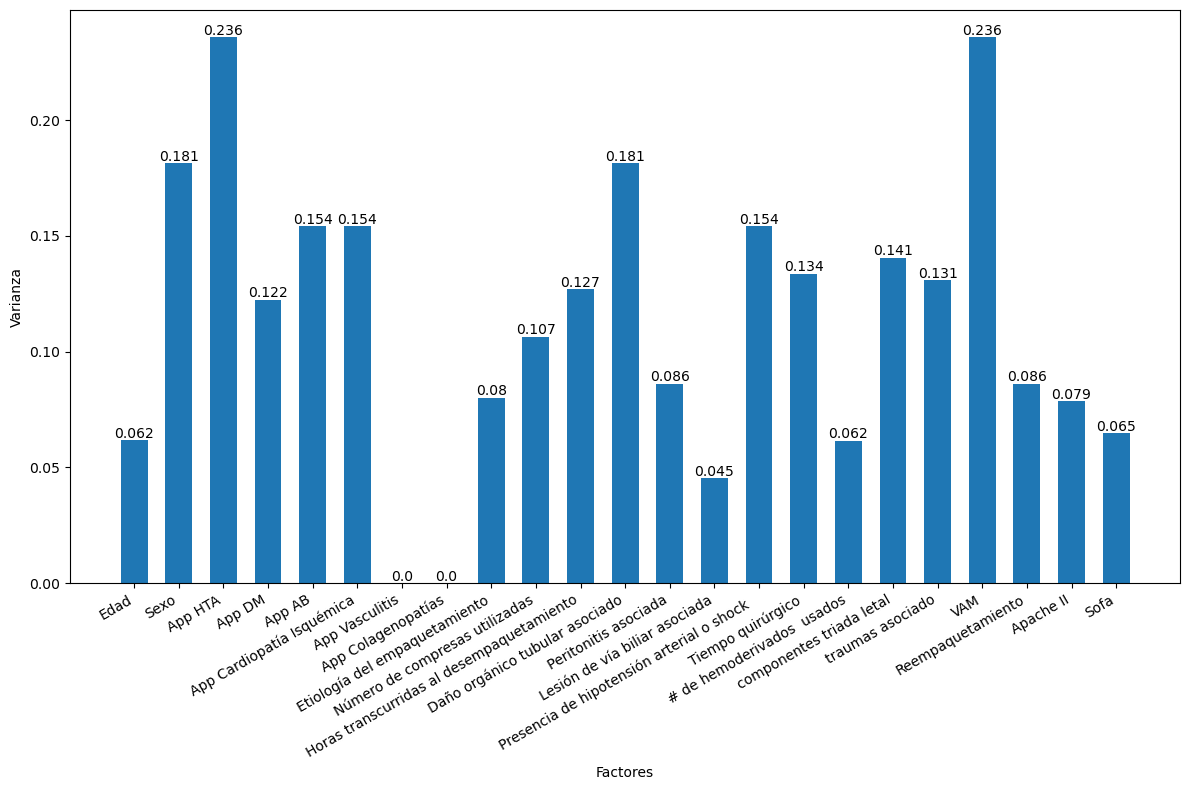

In [13]:
fig , ax = plt.subplots()

fig.set_size_inches(12,8)

x = X.columns
y_ = scaled_X.var(axis=0)

ax.bar(x, y_, width=0.6)
ax.set_xlabel('Factores')
ax.set_ylabel('Varianza')

for index, value in enumerate(y_):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')
    
fig.autofmt_xdate()
plt.tight_layout()

y_

In [14]:
X.drop(['App Vasculitis', 'App Colagenopatías'], axis=1, inplace=True)

<Axes: >

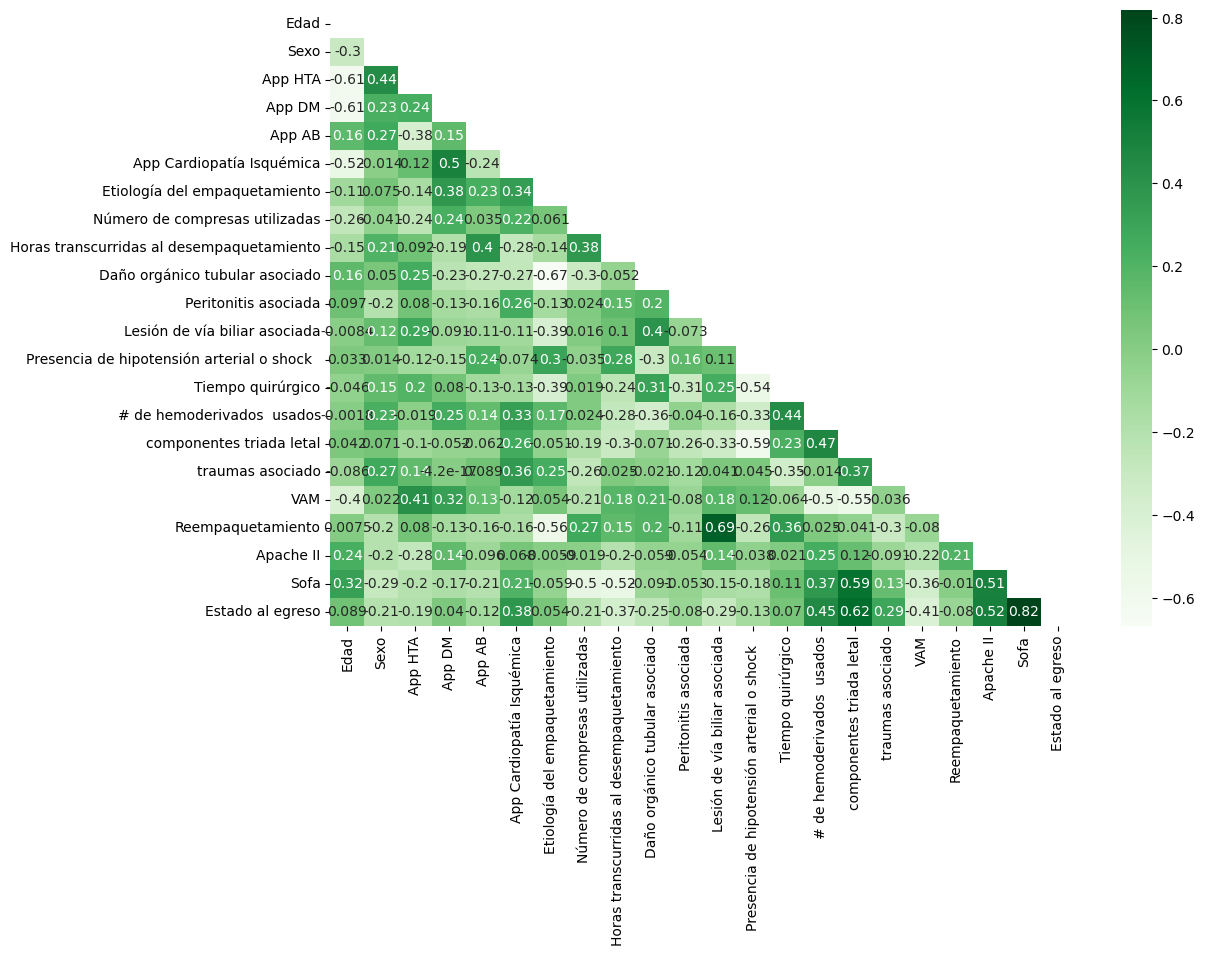

In [15]:
matrix = X.join(y).corr()
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(12,8))
sns.heatmap(matrix, annot=True, cmap='Greens', mask=mask)


In [16]:
matrix['Estado al egreso'].sort_values(ascending=False)

Estado al egreso                               1.000000
Sofa                                           0.819522
componentes triada letal                       0.622669
Apache II                                      0.516811
# de hemoderivados  usados                     0.453623
App Cardiopatía Isquémica                      0.380521
traumas asociado                               0.289214
Edad                                           0.089428
Tiempo quirúrgico                              0.070213
Etiología del empaquetamiento                  0.053582
App DM                                         0.040032
Peritonitis asociada                          -0.079536
Reempaquetamiento                             -0.079536
App AB                                        -0.118913
Presencia de hipotensión arterial o shock     -0.130804
App HTA                                       -0.192308
Número de compresas utilizadas                -0.207397
Sexo                                          -0

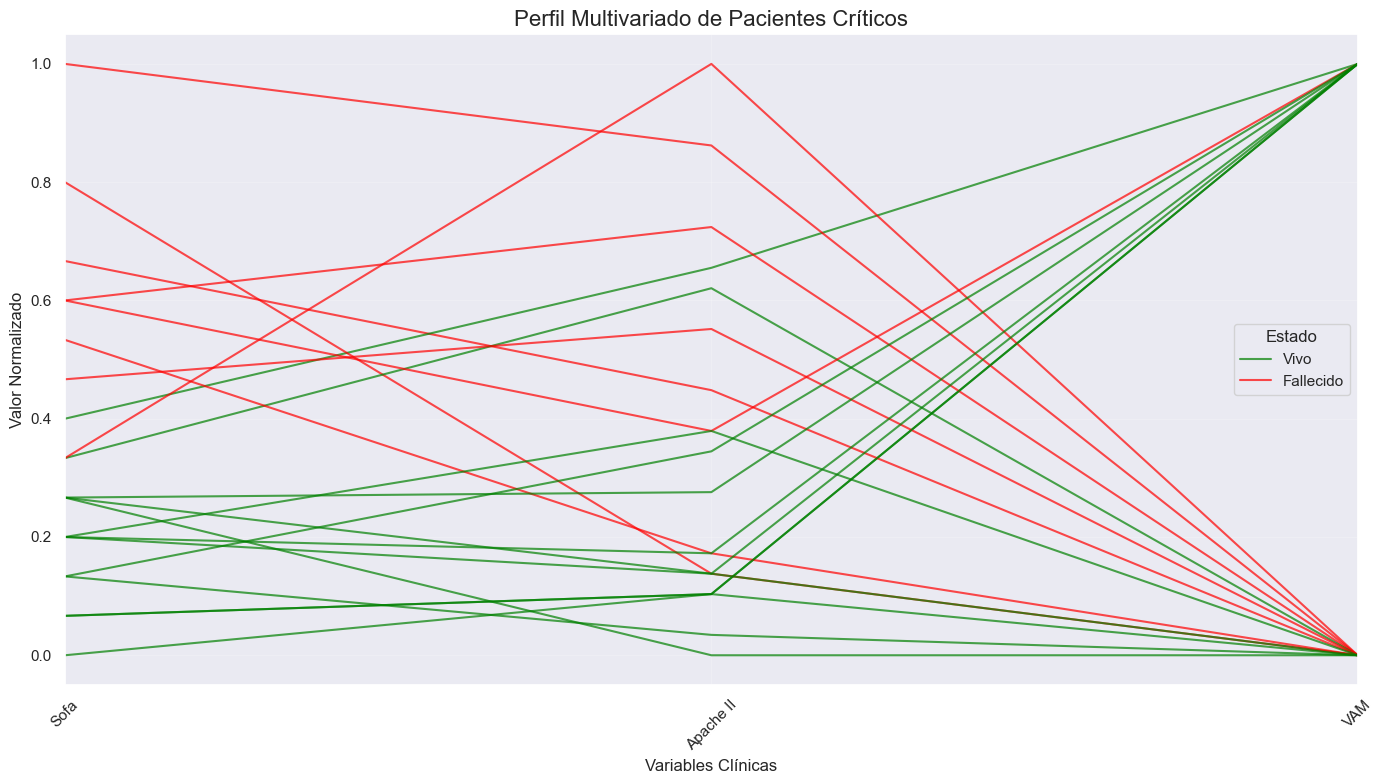

In [61]:

key_vars = ['Sofa', 'Apache II', 'VAM', 'Estado al egreso']
subset = data[key_vars].copy()

numeric_cols = key_vars[:-1]  

scaled_values = scaler.fit_transform(subset[numeric_cols].astype(float))
scaled_df = pd.DataFrame(scaled_values, columns=numeric_cols)
scaled_df['Estado al egreso'] = subset['Estado al egreso'].values


color_map = {1: 'green', 2: 'red'} 
colors = scaled_df['Estado al egreso'].map(color_map)


plt.figure(figsize=(14, 8))
pd.plotting.parallel_coordinates(
    scaled_df, 
    'Estado al egreso',
    color=colors.tolist(),
    axvlines=False,
    alpha=0.7
)


plt.title('Perfil Multivariado de Pacientes Críticos', fontsize=16)
plt.ylabel('Valor Normalizado', fontsize=12)
plt.xlabel('Variables Clínicas', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.2)
plt.legend(title='Estado', labels=['Vivo', 'Fallecido'])
plt.tight_layout()
plt.show()


Text(0.5, 0, 'Sofa')

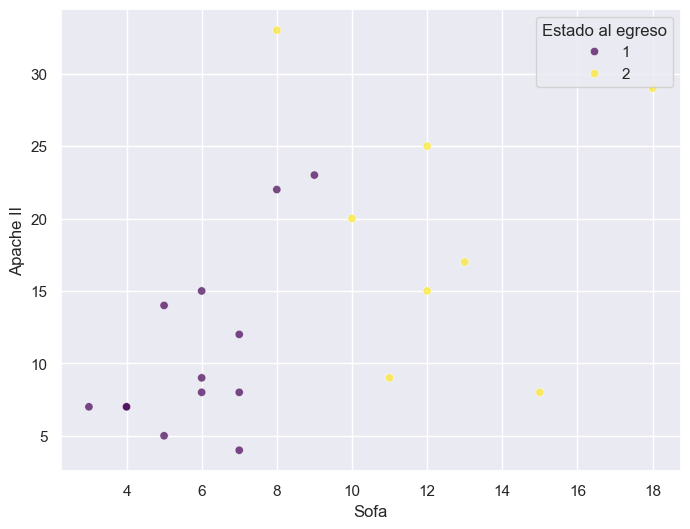

In [17]:
plt.figure(figsize=(8, 6))
sns.set(style='darkgrid')
sns.scatterplot(x='Sofa', y ='Apache II', data = data, hue='Estado al egreso', alpha =0.7, palette='viridis')
plt.ylabel('Apache II')
plt.xlabel('Sofa')

In [18]:
data = X.join(y)
data.to_csv('../data/data.csv', index=False)